# Hydra Smoke Dataset Visual Audit
This notebook recreates the Step 7 inspection flow: it reads the WebDataset shards emitted by
`src.data.preprocessing.stage_03_create_shards`, reconstructs every sample in the smoke dataset, and
plots them for quick QA. Set the `HYDRA_SMOKE_DATASET_DIR` environment variable if you want to point at
a dataset key other than `data/processed/hest_v1_smoke`.

Each subplot title now displays the sample's spatial technology label (if the metadata CSV is found),
and the caption underneath reports the mean inter-spot gap (nearest-neighbor distance minus patch size)
plus the spot count for that shard.

In [1]:
# Imports and project-root bootstrap
import io
import json
import logging
import os
import tarfile
from concurrent.futures import ThreadPoolExecutor, as_completed
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm

import rootutils

try:
    PROJECT_ROOT = Path(rootutils.setup_root(__file__, indicator=".project-root", pythonpath=True))
except NameError:
    PROJECT_ROOT = Path(rootutils.setup_root(search_from=".", indicator=".project-root", pythonpath=True))

logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")
logger = logging.getLogger("hydra_smoke")

In [2]:
# Dataset configuration and quick sanity checks
HYDRA_SMOKE_DATASET_DIR = Path(
    os.getenv("HYDRA_SMOKE_DATASET_DIR", PROJECT_ROOT / "data/processed/hest_v1_multitech_smoke")
)

if not HYDRA_SMOKE_DATASET_DIR.exists():
    raise FileNotFoundError(
        f"Dataset folder not found at {HYDRA_SMOKE_DATASET_DIR}. Run Stage 3 or set HYDRA_SMOKE_DATASET_DIR."
    )

sample_dirs = sorted(path for path in HYDRA_SMOKE_DATASET_DIR.iterdir() if path.is_dir())
if not sample_dirs:
    raise RuntimeError(f"No sample subdirectories detected under {HYDRA_SMOKE_DATASET_DIR}.")

logger.info("Scanning %d sample directories under %s", len(sample_dirs), HYDRA_SMOKE_DATASET_DIR)
for path in sample_dirs:
    logger.info(" • %s", path.name)

2025-11-16 17:19:25,838 [INFO] Scanning 5 sample directories under /cpfs01/projects-HDD/cfff-afe2df89e32e_HDD/jjh_19301050235/git_repo/Spatial-Clip/data/processed/hest_v1_multitech_smoke
2025-11-16 17:19:25,838 [INFO]  • MISC52
2025-11-16 17:19:25,838 [INFO]  • NCBI461
2025-11-16 17:19:25,838 [INFO]  • NCBI759
2025-11-16 17:19:25,839 [INFO]  • NCBI858
2025-11-16 17:19:25,839 [INFO]  • TENX158
2025-11-16 17:19:25,838 [INFO]  • MISC52
2025-11-16 17:19:25,838 [INFO]  • NCBI461
2025-11-16 17:19:25,838 [INFO]  • NCBI759
2025-11-16 17:19:25,839 [INFO]  • NCBI858
2025-11-16 17:19:25,839 [INFO]  • TENX158


In [3]:
# Build sample -> platform lookup from metadata CSV (manifest-driven fallback)
metadata_manifest_path = HYDRA_SMOKE_DATASET_DIR / "manifest.json"


def _candidate_metadata_paths():
    candidates = []
    if metadata_manifest_path.exists():
        try:
            manifest_data = json.loads(metadata_manifest_path.read_text(encoding="utf-8"))
            metadata_path_str = (
                manifest_data.get("hydra_config", {})
                .get("resolved", {})
                .get("source", {})
                .get("hest_metadata_csv")
            )
            if metadata_path_str:
                metadata_path = Path(metadata_path_str)
                if not metadata_path.is_absolute():
                    metadata_path = (PROJECT_ROOT / metadata_path).resolve()
                candidates.append(metadata_path)
        except Exception as exc:
            logger.warning("Failed to parse manifest for metadata reference: %s", exc)
    # Fallback paths commonly used in the repo
    candidates.append((PROJECT_ROOT / "data/raw/hest_v1/HEST_v1_1_0.csv").resolve())
    candidates.append((PROJECT_ROOT / "data/hest_1k_original/HEST_v1_1_0.csv").resolve())

    unique_candidates = []
    for path in candidates:
        if path not in unique_candidates:
            unique_candidates.append(path)
    return unique_candidates


def build_platform_lookup() -> dict:
    sample_cols = ("sample_id", "Sample ID", "sample", "Sample", "id")
    platform_cols = ("st_technology", "technology", "platform", "tech_platform")

    for candidate in _candidate_metadata_paths():
        if not candidate.exists():
            continue
        logger.info("Loading sample metadata from %s", candidate)
        try:
            df = pd.read_csv(candidate)
        except Exception as exc:
            logger.warning("Failed to read %s: %s", candidate, exc)
            continue

        sample_col = next((col for col in sample_cols if col in df.columns), None)
        platform_col = next((col for col in platform_cols if col in df.columns), None)
        if not sample_col or not platform_col:
            logger.warning(
                "Metadata file %s missing required columns (sample=%s, platform=%s)",
                candidate,
                sample_col,
                platform_col,
            )
            continue

        mapping = (
            df[[sample_col, platform_col]]
            .dropna()
            .assign(**{sample_col: lambda d: d[sample_col].astype(str).str.strip()})
            .assign(**{platform_col: lambda d: d[platform_col].astype(str).str.strip()})
            .set_index(sample_col)[platform_col]
            .to_dict()
        )
        if mapping:
            logger.info("Discovered platform metadata for %d samples", len(mapping))
            return mapping

    logger.warning("No usable metadata file found; platform titles will fall back to 'Unknown tech'.")
    return {}


PLATFORM_LOOKUP = build_platform_lookup()

2025-11-16 17:19:25,852 [INFO] Loading sample metadata from /cpfs01/projects-HDD/cfff-afe2df89e32e_HDD/jjh_19301050235/git_repo/Spatial-Clip/data/raw/hest_v1/HEST_v1_1_0.csv
2025-11-16 17:19:25,868 [INFO] Discovered platform metadata for 1229 samples
2025-11-16 17:19:25,868 [INFO] Discovered platform metadata for 1229 samples


In [4]:
# Helper utilities for shard loading and reconstruction
def load_spots_from_shard(tar_path: Path):
    png_buffers = {}
    metadata = {}
    with tarfile.open(tar_path, "r:*") as shard:
        for member in shard:
            if not member.isfile():
                continue
            member_path = Path(member.name)
            key = member_path.stem
            suffix = member_path.suffix.lower()
            file_obj = shard.extractfile(member)
            if file_obj is None:
                continue
            if suffix == ".png":
                png_buffers[key] = file_obj.read()
            elif suffix == ".json":
                metadata[key] = json.load(file_obj)
    spots = []
    for key, meta in metadata.items():
        png_bytes = png_buffers.get(key)
        if png_bytes is None:
            continue
        spots.append(
            {
                "sample_id": meta.get("sample_id"),
                "x": int(meta.get("x", 0)),
                "y": int(meta.get("y", 0)),
                "png_bytes": png_bytes,
            }
        )
    return spots


def compute_mean_gap_px(coords: np.ndarray, tile_size: int) -> float:
    if coords.shape[0] < 2:
        return 0.0
    diffs = coords[:, None, :] - coords[None, :, :]
    distances = np.sqrt(np.sum(diffs**2, axis=-1, dtype=np.float64))
    np.fill_diagonal(distances, np.inf)
    nearest = distances.min(axis=1)
    gap_value = float(nearest.mean() - tile_size)
    return max(round(gap_value, 2), 0.0)


def reconstruct_from_wds_shard(tar_path: Path, sample_id: str):
    spots = load_spots_from_shard(tar_path)
    if not spots:
        logger.warning("[%s] Shard %s contained no usable records.", sample_id, tar_path.name)
        return None
    with Image.open(io.BytesIO(spots[0]["png_bytes"])) as first_tile:
        tile_w, tile_h = first_tile.size
    xs = [spot["x"] for spot in spots]
    ys = [spot["y"] for spot in spots]
    min_x, max_x = min(xs), max(xs)
    min_y, max_y = min(ys), max(ys)
    canvas = Image.new(
        "RGB",
        ((max_x - min_x) + tile_w, (max_y - min_y) + tile_h),
        "black",
    )
    logger.info("[%s] Reconstructing %d tiles from %s", sample_id, len(spots), tar_path.name)
    coords = np.array([[spot["x"], spot["y"]] for spot in spots], dtype=np.float32)
    for spot in tqdm(spots, desc=f"Hydra paste {sample_id}", leave=False):
        tile = Image.open(io.BytesIO(spot["png_bytes"]))
        paste_x = spot["x"] - tile_w // 2 - min_x
        paste_y = spot["y"] - tile_h // 2 - min_y
        canvas.paste(tile, (paste_x, paste_y))
        tile.close()
    return {
        "image": canvas,
        "tile_size": tile_w,
        "mean_gap_px": compute_mean_gap_px(coords, tile_w),
        "spot_count": len(spots),
    }


def reconstruct_sample_dir(sample_dir: Path):
    shard_candidates = sorted(sample_dir.glob("*.tar"))
    if not shard_candidates:
        logger.warning("[%s] No shard files found under %s", sample_dir.name, sample_dir)
        return None
    return reconstruct_from_wds_shard(shard_candidates[0], sample_dir.name)

Reconstructing samples:   0%|          | 0/5 [00:00<?, ?it/s]

2025-11-16 17:19:26,644 [INFO] [NCBI759] Reconstructing 462 tiles from NCBI759_000000.tar
2025-11-16 17:19:26,705 [INFO] [MISC52] Reconstructing 229 tiles from MISC52_000000.tar
2025-11-16 17:19:26,705 [INFO] [MISC52] Reconstructing 229 tiles from MISC52_000000.tar


Hydra paste NCBI759:   0%|          | 0/462 [00:00<?, ?it/s]

Hydra paste MISC52:   0%|          | 0/229 [00:00<?, ?it/s]

2025-11-16 17:19:27,161 [INFO] [NCBI858] Reconstructing 837 tiles from NCBI858_000000.tar


Hydra paste NCBI858:   0%|          | 0/837 [00:00<?, ?it/s]

2025-11-16 17:19:28,013 [INFO] [NCBI461] Reconstructing 1987 tiles from NCBI461_000000.tar


Hydra paste NCBI461:   0%|          | 0/1987 [00:00<?, ?it/s]

2025-11-16 17:19:29,450 [INFO] [TENX158] Reconstructing 2179 tiles from TENX158_000000.tar


Hydra paste TENX158:   0%|          | 0/2179 [00:00<?, ?it/s]

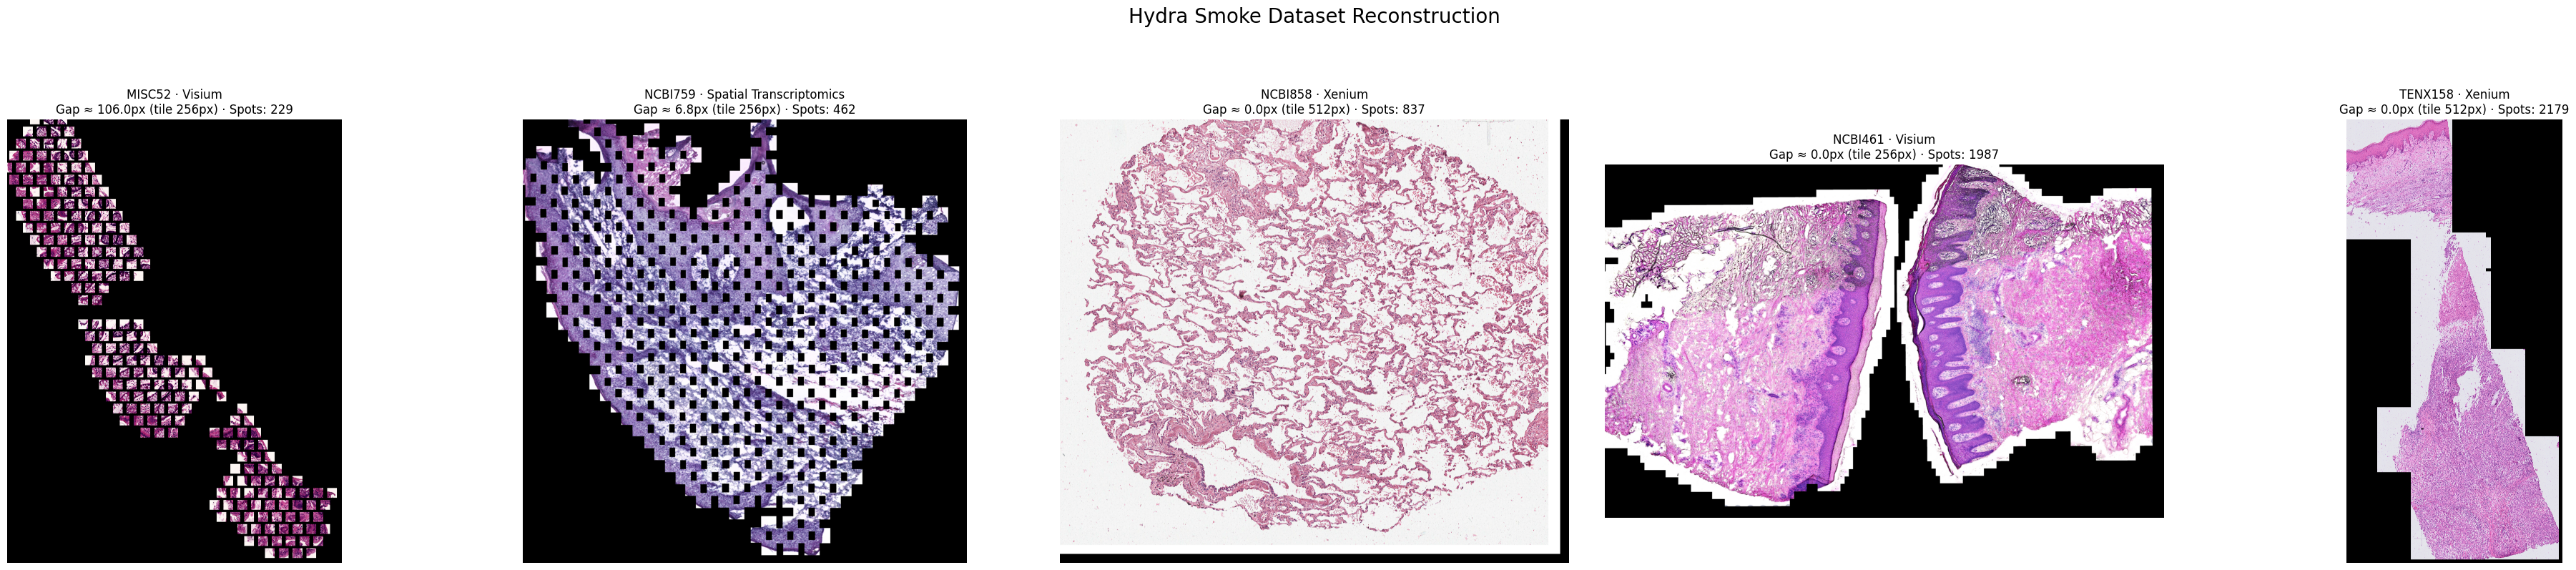

In [5]:
# Execute reconstruction for each sample and visualize results
reconstructed_images = []
max_workers = min(len(sample_dirs), os.cpu_count() or 4)

with ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = {executor.submit(reconstruct_sample_dir, sample_dir): sample_dir for sample_dir in sample_dirs}
    for future in tqdm(as_completed(futures), total=len(futures), desc="Reconstructing samples"):
        sample_dir = futures[future]
        try:
            recon_payload = future.result()
        except Exception as exc:
            logger.error("Sample %s reconstruction failed: %s", sample_dir.name, exc, exc_info=True)
            continue
        if recon_payload:
            recon_payload.update(
                {
                    "id": sample_dir.name,
                    "tech": PLATFORM_LOOKUP.get(sample_dir.name, "Unknown tech"),
                }
            )
            reconstructed_images.append(recon_payload)

if not reconstructed_images:
    raise RuntimeError("No reconstructions succeeded. Check logs for details.")

cols = len(reconstructed_images)
fig, axes = plt.subplots(1, cols, figsize=(8 * cols, 8), squeeze=False)
fig.suptitle("Hydra Smoke Dataset Reconstruction", fontsize=20, y=1.02)

for idx, result in enumerate(reconstructed_images):
    ax = axes[0, idx]
    ax.imshow(result["image"])
    platform_label = result.get("tech") or "Unknown tech"
    gap_value = result.get("mean_gap_px")
    tile_px = result.get("tile_size")
    spot_count = result.get("spot_count")
    if gap_value is not None and tile_px is not None:
        gap_text = f"Gap ≈ {gap_value:.1f}px (tile {int(tile_px)}px)"
    else:
        gap_text = "Gap unavailable"
    if spot_count is not None:
        gap_text = f"{gap_text} · Spots: {spot_count}"
    title_text = f"{result['id']} · {platform_label}\n{gap_text}"
    ax.set_title(title_text, fontsize=12)
    ax.axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()